In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def apply_gaussian_filter(image, sigma):

    # Calculate kernel size (odd and at least 3x3)
    ksize = int(6 * sigma + 1)
    if ksize % 2 == 0:
        ksize += 1

    # Create 2D Gaussian kernel
    ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernal= kernel / np.sum(kernel)  # Normalize the kernel

    # kernel_2d = np.array([[1, 2, 1],
    #                  [2, 4, 2],
    #                  [1, 2, 1]], dtype=np.float32) / 16

    # Apply filter using convolution
    filtered = cv2.filter2D(image, -1, kernal)

    return filtered


In [ ]:


def bilateral_filter(image, sigma_s, sigma_r):
    image = image.astype(np.float32)
    ksize = int(6 * sigma_s + 1) | 1  # Ensure odd kernel size
    half_ksize = ksize // 2

    # Create spatial kernel
    x, y = np.mgrid[-half_ksize:half_ksize+1, -half_ksize:half_ksize+1]
    spatial_kernel = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

    # Pad image to handle borders
    padded = cv2.copyMakeBorder(image, half_ksize, half_ksize, half_ksize, half_ksize, cv2.BORDER_REFLECT)
    filtered = np.zeros_like(image)

    # Apply filter
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+ksize, j:j+ksize]
            range_kernel = np.exp(-((region - image[i, j])**2) / (2 * sigma_r**2))
            kernel = spatial_kernel * range_kernel
            kernel /= kernel.sum()
            filtered[i, j] = (region * kernel).sum()

    return filtered.astype(np.uint8)

In [ ]:

def roberts_operator(image):
    """Apply Roberts edge detection operator."""
    image = image.astype(np.float32)/255.0
    kernel_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
    kernel_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
    grad_x = cv2.filter2D(image, -1, kernel_x)
    grad_y = cv2.filter2D(image, -1, kernel_y)
    gradient = np.sqrt(grad_x**2 + grad_y**2)
    gradient = (gradient / gradient.max()) * 255
    gradient[gradient > 255] = 255  # Ensure values do not exceed 255
    gradient[gradient < 0] = 0      # Ensure values are not below 0

    return gradient.astype(np.uint8)

In [ ]:
# def canny_operator(image, low_threshold=34, high_threshold=100):
#     """Apply Canny edge detection operator"""
#     return cv2.Canny(image, low_threshold, high_threshold)



import numpy as np
from scipy.ndimage import gaussian_filter, sobel

def canny_operator1(image, low_threshold=10, high_threshold=80):

    # Step 1: Noise Reduction using Gaussian filter
    # smoothed_image = gaussian_filter(image, sigma=1.4)

    # Step 2: Gradient Calculation using Sobel filters
    gradient_x = sobel(image, axis=0)
    gradient_y = sobel(image, axis=1)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)

    # Step 3: Non-Maximum Suppression
    def non_maximum_suppression(magnitude, direction):
        suppressed = np.zeros_like(magnitude)
        angle = direction % 180  # Normalize angles to [0, 180]

        rows, cols = magnitude.shape
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                q, r = 0, 0

                # Determine neighbors based on gradient direction
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j + 1]
                    r = magnitude[i, j - 1]
                elif (22.5 <= angle[i, j] < 67.5):
                    q = magnitude[i + 1, j - 1]
                    r = magnitude[i - 1, j + 1]
                elif (67.5 <= angle[i, j] < 112.5):
                    q = magnitude[i + 1, j]
                    r = magnitude[i - 1, j]
                elif (112.5 <= angle[i, j] < 157.5):
                    q = magnitude[i - 1, j - 1]
                    r = magnitude[i + 1, j + 1]

                # Suppress non-maximum values
                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    suppressed[i, j] = magnitude[i, j]

        return suppressed

    suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

    # Step 4: Double Thresholding
    strong_edges = suppressed_image >= high_threshold
    weak_edges = (suppressed_image >= low_threshold) & ~strong_edges

    # Step 5: Edge Tracking by Hysteresis
    def hysteresis_tracking(strong_edges, weak_edges):
        edges = np.copy(strong_edges)
        rows, cols = edges.shape

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if weak_edges[i, j]:
                    # Check if connected to strong edges
                    if np.any(strong_edges[i-1:i+2, j-1:j+2]):
                        edges[i, j] = True

        return edges

    final_edges = hysteresis_tracking(strong_edges.astype(bool), weak_edges.astype(bool))

    return final_edges.astype(np.uint8) * 255




def canny_operator(
    image,
    low_threshold=34,
    high_threshold=68,
    kernel_size=2,
    use_gaussian_blur=True,
    blur_kernel_size=5,
    blur_sigma=1.4,
    use_auto_thresholds=False,
    auto_threshold_ratio=.8,
    l2_gradient=False
):
    """
    Customizable Canny edge detector with preprocessing options

    Parameters:
    - image: Input image (grayscale)
    - low_threshold: Lower threshold for hysteresis procedure
    - high_threshold: Upper threshold for hysteresis procedure
    - kernel_size: Size of Sobel operator kernel (must be odd)
    - use_gaussian_blur: Whether to apply Gaussian blur preprocessing
    - blur_kernel_size: Size of Gaussian kernel (must be odd)
    - blur_sigma: Gaussian kernel standard deviation
    - use_auto_thresholds: Whether to calculate thresholds automatically
    - auto_threshold_ratio: Ratio for automatic threshold calculation (high_threshold = ratio * max_val)
    - l2_gradient: Whether to use L2 norm for gradient magnitude calculation

    Returns:
    - edges: Edge map image
    """

    # Validate kernel sizes
    if kernel_size % 2 == 0:
        kernel_size += 1
    if blur_kernel_size % 2 == 0:
        blur_kernel_size += 1

    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur if enabled
    if use_gaussian_blur:
        image = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), blur_sigma)

    # Calculate automatic thresholds if enabled
    if use_auto_thresholds:
        median_val = np.median(image)
        high_threshold = min(255, int(max(0, median_val * (1.0 + auto_threshold_ratio))))
        low_threshold = max(0, int(high_threshold * 0.5))

    # Apply Canny edge detection
    edges = cv2.Canny(
        image=image,
        threshold1=low_threshold,
        threshold2=high_threshold,
        apertureSize=kernel_size,
        L2gradient=l2_gradient
    )

    return edges






In [ ]:

def frei_chen_operator(image):

    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Normalize
    image = image.astype(np.float32)/255.0

    # Kernels
    sqrt2 = np.sqrt(2)
    g1 = np.array([[1, sqrt2, 1], [0,0,0], [-1,-sqrt2,-1]])/(2+2*sqrt2)
    g2 = np.array([[1,0,-1], [sqrt2,0,-sqrt2], [1,0,-1]])/(2+2*sqrt2)

    # Convolve
    grad1 = cv2.filter2D(image, -1, g1)
    grad2 = cv2.filter2D(image, -1, g2)

    # Magnitude
    grad_mag = np.sqrt(grad1**2 + grad2**2)
    grad_mag = (grad_mag/grad_mag.max() * 255).astype(np.uint8)

    # Auto-thresholding
    high_thresh = max(30, grad_mag.max() * 0.2)
    low_thresh = high_thresh * 0.5
    edges = np.zeros_like(grad_mag)
    edges[grad_mag > high_thresh] = 255
    #edges[(grad_mag >= low_thresh) & (grad_mag <= high_thresh)] = 128
    edges[grad_mag < low_thresh] = 0

    return edges

In [ ]:
def mean_squared_error(original, processed):

    # Ensure inputs are numpy arrays and have same shape
    original = np.asarray(original)
    processed = np.asarray(processed)

    if original.shape != processed.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert to float64 to prevent overflow
    original = original.astype(np.float64)
    processed = processed.astype(np.float64)

    # Calculate MSE
    mse = np.mean((original - processed) ** 2)

    return mse

def peak_signal_noise_ratio(original, processed, data_range=255):

    # Calculate MSE first
    mse = mean_squared_error(original, processed)

    # Handle case where MSE is zero (perfect match)
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    psnr = 10 * np.log10((data_range ** 2) / mse)

    return psnr

In [ ]:
def evaluate_results(original, processed):
    """Calculate MSE and PSNR between original and processed images"""
    mse = mean_squared_error(original, processed)
    psnr = peak_signal_noise_ratio(original, processed, data_range=255)
    return mse, psnr

def process_image(image_path, sigma_gaussian, sigma_s, sigma_r):
    """Main processing function"""
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or couldn't be loaded")

    # Resize to 300x300 as in the paper
    image = cv2.resize(image, (300, 300))

    # Apply Gaussian filter
    gaussian_filtered = apply_gaussian_filter(image, sigma_gaussian)

    # Apply Bilateral filter
    bilateral_filtered = bilateral_filter(image, sigma_s, sigma_r)

    # Edge detection on Gaussian filtered image
    roberts_gaussian = roberts_operator(gaussian_filtered)
    canny_gaussian = canny_operator(gaussian_filtered)
    frei_chen_gaussian = frei_chen_operator(gaussian_filtered)

    # Edge detection on Bilateral filtered image
    roberts_bilateral = roberts_operator(bilateral_filtered)
    canny_bilateral = canny_operator(bilateral_filtered)
    frei_chen_bilateral = frei_chen_operator(bilateral_filtered)

    # Evaluate results
    results = {
        'Gaussian Filter': {
            'Roberts': evaluate_results(image, roberts_gaussian),
            'Canny': evaluate_results(image, canny_gaussian),
            'Frei-Chen': evaluate_results(image, frei_chen_gaussian)
        },
        'Bilateral Filter': {
            'Roberts': evaluate_results(image, roberts_bilateral),
            'Canny': evaluate_results(image, canny_bilateral),
            'Frei-Chen': evaluate_results(image, frei_chen_bilateral)
        }
    }

    # Display results
    plt.figure(figsize=(15, 10))

    # Original and filtered images
    plt.subplot(3, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(3, 3, 2)
    plt.imshow(gaussian_filtered, cmap='gray')
    plt.title(f'Gaussian Filter\nσ={sigma_gaussian}')
    plt.axis('off')

    plt.subplot(3, 3, 3)
    plt.imshow(bilateral_filtered, cmap='gray')
    plt.title(f'Bilateral Filter\nσ_s={sigma_s}, σ_r={sigma_r}')
    plt.axis('off')

    # Gaussian filter edge detection
    plt.subplot(3, 3, 4)
    plt.imshow(roberts_gaussian, cmap='gray')
    plt.title('Roberts (Gaussian)')
    plt.axis('off')

    plt.subplot(3, 3, 5)
    plt.imshow(canny_gaussian, cmap='gray')
    plt.title('Canny (Gaussian)')
    plt.axis('off')

    plt.subplot(3, 3, 6)
    plt.imshow(frei_chen_gaussian, cmap='gray')
    plt.title('Frei-Chen (Gaussian)')
    plt.axis('off')

    # Bilateral filter edge detection
    plt.subplot(3, 3, 7)
    plt.imshow(roberts_bilateral, cmap='gray')
    plt.title('Roberts (Bilateral)')
    plt.axis('off')

    plt.subplot(3, 3, 8)
    plt.imshow(canny_bilateral, cmap='gray')
    plt.title('Canny (Bilateral)')
    plt.axis('off')

    plt.subplot(3, 3, 9)
    plt.imshow(frei_chen_bilateral, cmap='gray')
    plt.title('Frei-Chen (Bilateral)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return results



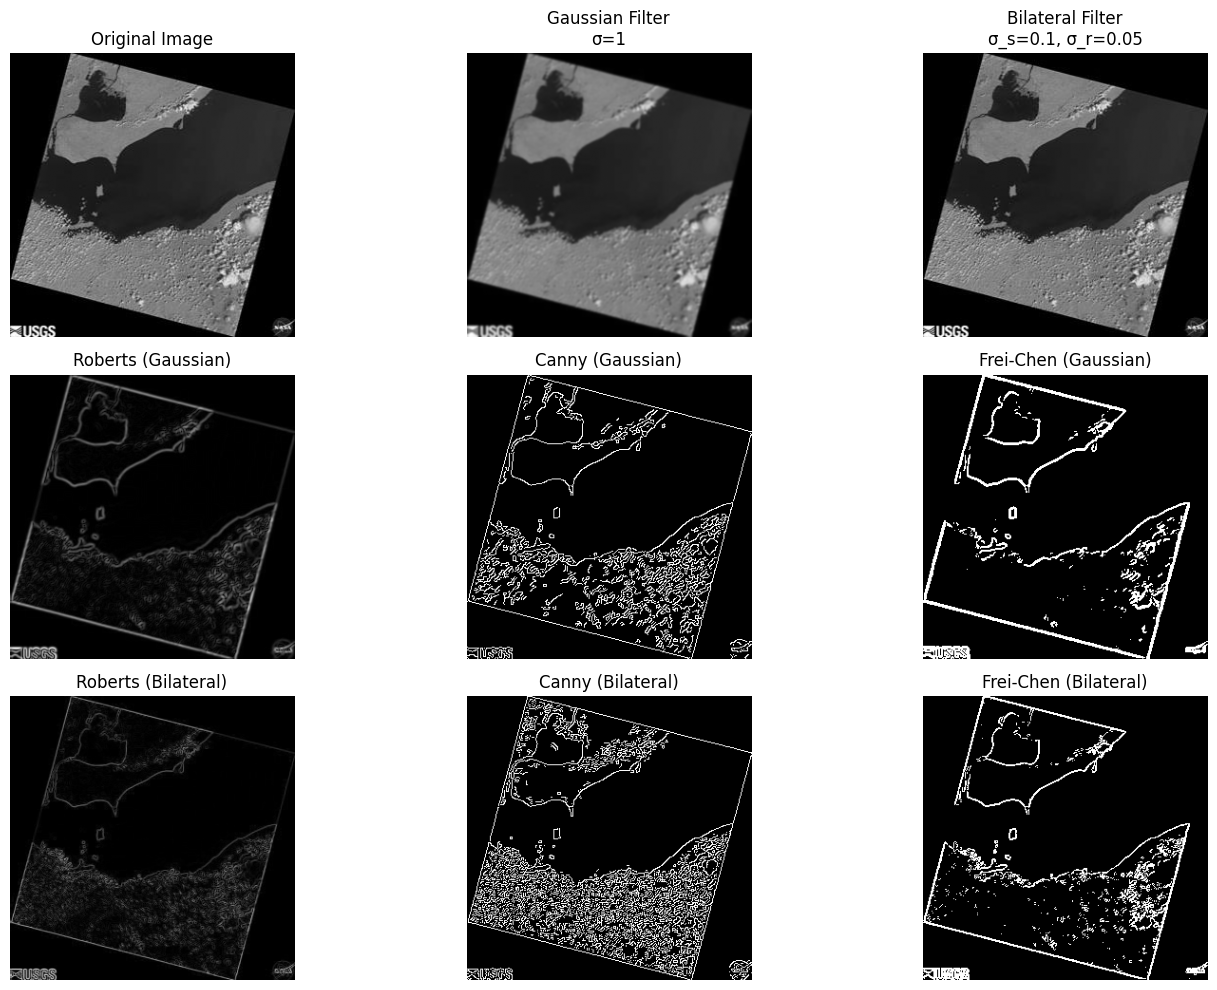


Evaluation Results:

Gaussian Filter:
Roberts: MSE = 5254.24, PSNR = 10.93 dB
Canny: MSE = 7671.26, PSNR = 9.28 dB
Frei-Chen: MSE = 8336.57, PSNR = 8.92 dB

Bilateral Filter:
Roberts: MSE = 5085.73, PSNR = 11.07 dB
Canny: MSE = 7723.18, PSNR = 9.25 dB
Frei-Chen: MSE = 7897.47, PSNR = 9.16 dB


In [ ]:
# Example usage 2
if __name__ == "__main__":
    #satellite image path
    image_path = "/content/drive/MyDrive/DIP project/15.jpg"

    # Parameters from the paper
    sigma_gaussian = 1 # Standard deviation for Gaussian filter
    sigma_s = 10        # Spatial parameter for Bilateral filter
    sigma_r = 1       # Range parameter for Bilateral filter

    results = process_image(image_path, sigma_gaussian, sigma_s, sigma_r)

    # Print evaluation results
    print("\nEvaluation Results:")
    for filter_type in results:
        print(f"\n{filter_type}:")
        for operator in results[filter_type]:
            mse, psnr = results[filter_type][operator]
            print(f"{operator}: MSE = {mse:.2f}, PSNR = {psnr:.2f} dB")

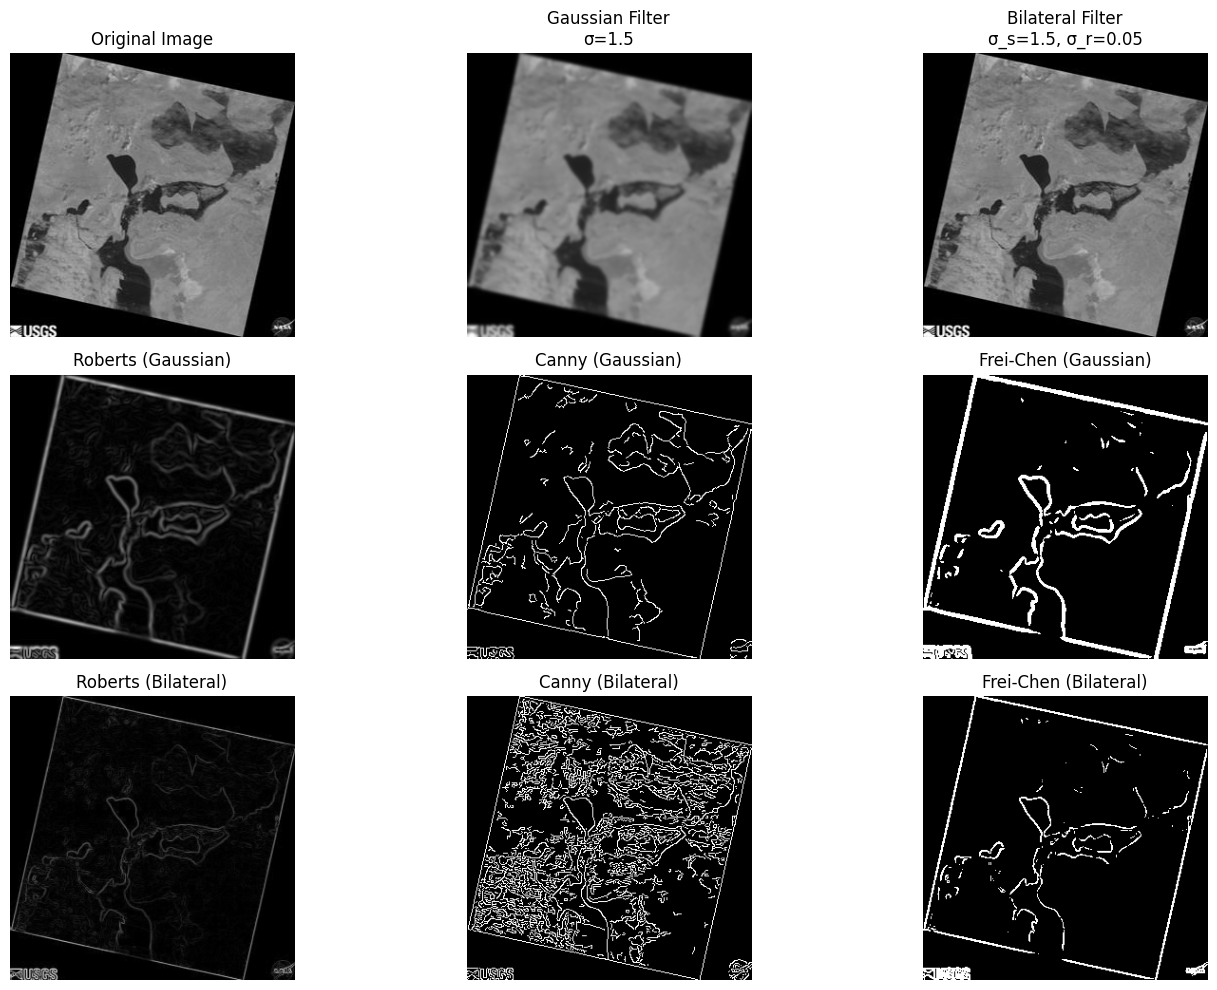


Evaluation Results:

Gaussian Filter:
Roberts: MSE = 8451.96, PSNR = 8.86 dB
Canny: MSE = 11349.09, PSNR = 7.58 dB
Frei-Chen: MSE = 12802.19, PSNR = 7.06 dB

Bilateral Filter:
Roberts: MSE = 9089.52, PSNR = 8.55 dB
Canny: MSE = 11754.12, PSNR = 7.43 dB
Frei-Chen: MSE = 11564.15, PSNR = 7.50 dB


In [ ]:
# Example usage 1
if __name__ == "__main__":
    #satellite image path
    image_path = "/content/drive/MyDrive/DIP project/7.jpg"

    # Parameters from the paper
    sigma_gaussian = 1.5  # Standard deviation for Gaussian filter
    sigma_s = 1.5         # Spatial parameter for Bilateral filter
    sigma_r = 0.05        # Range parameter for Bilateral filter

    results = process_image(image_path, sigma_gaussian, sigma_s, sigma_r)

    # Print evaluation results
    print("\nEvaluation Results:")
    for filter_type in results:
        print(f"\n{filter_type}:")
        for operator in results[filter_type]:
            mse, psnr = results[filter_type][operator]
            print(f"{operator}: MSE = {mse:.2f}, PSNR = {psnr:.2f} dB")

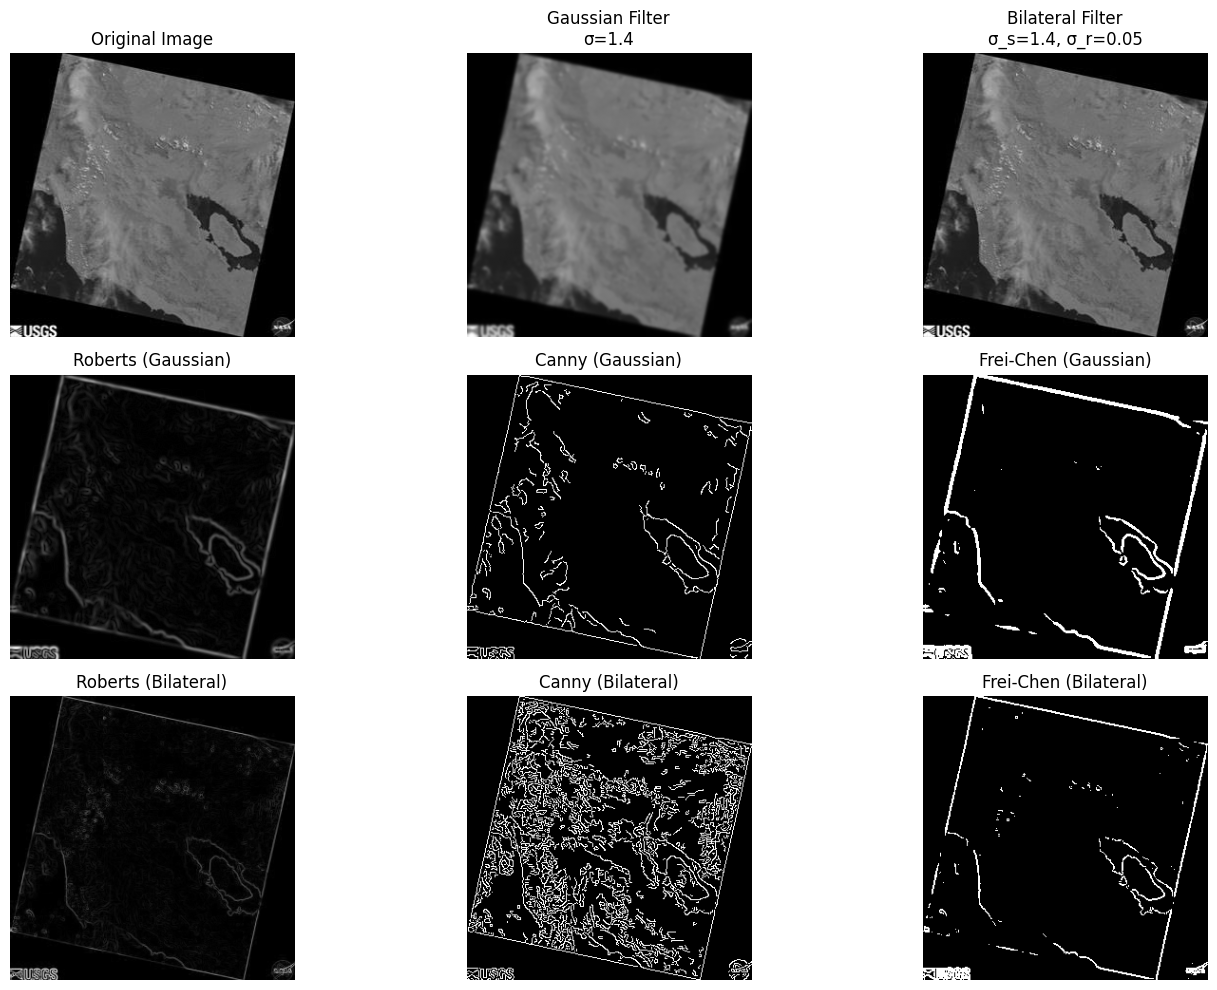


Evaluation Results:

Gaussian Filter:
Roberts: MSE = 6648.50, PSNR = 9.90 dB
Canny: MSE = 9103.20, PSNR = 8.54 dB
Frei-Chen: MSE = 9825.09, PSNR = 8.21 dB

Bilateral Filter:
Roberts: MSE = 6957.32, PSNR = 9.71 dB
Canny: MSE = 10181.57, PSNR = 8.05 dB
Frei-Chen: MSE = 8957.27, PSNR = 8.61 dB


In [ ]:

# Example usage 2
if __name__ == "__main__":
    #satellite image path
    image_path = "/content/drive/MyDrive/DIP project/11.jpg"

    # Parameters from the paper
    sigma_gaussian = 1.4  # Standard deviation for Gaussian filter
    sigma_s = 1.4         # Spatial parameter for Bilateral filter
    sigma_r = 0.05        # Range parameter for Bilateral filter

    results = process_image(image_path, sigma_gaussian, sigma_s, sigma_r)

    # Print evaluation results
    print("\nEvaluation Results:")
    for filter_type in results:
        print(f"\n{filter_type}:")
        for operator in results[filter_type]:
            mse, psnr = results[filter_type][operator]
            print(f"{operator}: MSE = {mse:.2f}, PSNR = {psnr:.2f} dB")